In [324]:
import numpy as np
import pandas as pd
from itertools import *
from pulp import *
import riskfolio as rp 
import warnings 
import datetime as datetime
import yfinance as yf
from bs4 import BeautifulSoup
import requests
from pulp import *
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import Markdown as md
%matplotlib inline


# 1

In [325]:
'''
Data Import for Current Term Structure
---
Imports all active treasury bonds data, time indexes them by year
'''
data_prompt = pd.read_excel('Table.xlsx', sheet_name='PromptUse', index_col = 'DateDue')
data_prompt = data_prompt/1000
term_structure_df = pd.read_excel('Table.xlsx', sheet_name='Bills Bonds and Notes')
term_structure_df['px_last'] = [i if i>=5 else 100 - i for i in term_structure_df['ASKED'].to_list()]
term_structure_df['ttm'] = [(i - datetime.datetime.now())/datetime.timedelta(days=365) for i in term_structure_df['MATURITY']]

In [326]:
'''
Bootstrap yield curve
---
begins with zero-coupon bonds to payout (ttm < 0.5 yrs) & calculates yield
moves to coupon bonds and uses calculated yields to bootstrap further
sorts all bonds into data frame indexed by ttm (by 100th of a year)
NOTE: Averages yields for the same time period
NOTE: assumes yield of period prior if yield for desired period does not exist
'''

'''short term rates'''
mats = []
round_to = 2
for bond_tenor in term_structure_df[term_structure_df['ttm'] <= 0.5].index:
    bond = term_structure_df.loc[bond_tenor]
    cpn = bond['COUPON']/2
    ttm = bond['ttm']
    px = bond['px_last']
    mats.append([np.round(ttm,round_to),np.log((100 + cpn) / bond['px_last']) / bond['ttm']])
rates = pd.DataFrame(mats, columns=['ttm','rate']).set_index('ttm').groupby('ttm').mean()

'''longer term rates'''
for bond_tenor in term_structure_df[term_structure_df['ttm']>=0.5].index:
    bond = term_structure_df.loc[bond_tenor]
    px = bond['px_last']
    ttm = bond['ttm']
    cpn = bond['COUPON']/2
    pmts = int(np.ceil(ttm * 2))
    cfs = [cpn if i+1<pmts else 100 + cpn for i in range(pmts)]
    cfs_idx = [np.round(ttm-i*0.5, round_to) for i in reversed(range(pmts))]
    known_rates = [rates[:cfs_idx[i]].iloc[-1,0] for i in range(pmts-1)]
    val = px - sum([cpn * np.exp((-1) * known_rates[i] * cfs_idx[i]) for i in range(pmts-1)])
    yld = (-1) * (np.log(val / (100+cpn)) / cfs_idx[pmts-1])
    add_df = pd.DataFrame([np.round(ttm, round_to), yld], index=['ttm','rate']).transpose().set_index('ttm')
    rates = pd.concat([rates,add_df],ignore_index=False)
    rates = rates.groupby('ttm').mean()

Text(0, 0.5, 'Yield in Percentage Points')

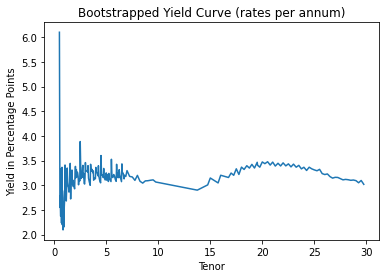

In [327]:
'''
plot yield curve
---
plots yield curve in percentage points
'''
plt.plot(rates[0.5:] * 100)
plt.title('Bootstrapped Yield Curve (rates per annum)')
plt.xlabel('Tenor')
plt.ylabel('Yield in Percentage Points')

In [328]:
rates

,rate
ttm,
-0.03,-0.019260
-0.02,-0.045680
-0.01,-0.130745
-0.00,-2.067507
0.01,0.289427
...,...
28.77,0.031061
29.02,0.030931
29.27,0.030506


In [329]:
data_prompt = pd.read_excel('Table.xlsx', sheet_name='PromptUse', index_col = 'DateDue')
data_prompt['ttm'] = np.round((data_prompt.index - datetime.datetime.now()) / datetime.timedelta(days=365), round_to)

r = []
for ttm in data_prompt['ttm']:
    r.append(rates[:ttm].iloc[-1,0])
data_prompt['rates'] = r

npv = sum([data_prompt.iloc[i,0]*np.exp((-1) * data_prompt.iloc[i,1] * data_prompt.iloc[i,2]) for i in range(len(data_prompt))])
dur = sum([data_prompt.iloc[i,1]*data_prompt.iloc[i,0]*np.exp((-1) * data_prompt.iloc[i,1] * data_prompt.iloc[i,2]) for i in range(len(data_prompt))])
con = sum([data_prompt.iloc[i,1]*(data_prompt.iloc[i,1]+1)*data_prompt.iloc[i,0]*np.exp((-1) * (data_prompt.iloc[i,1] + 2 ) * data_prompt.iloc[i,2]) for i in range(len(data_prompt))])

In [330]:
# Using markdown outputs instead of just printing

md('''
<center>

### Solutions

The Net Present Value of the Liabilities is $\${:.2f}$ MM

The Macauley Duration of the Liability stream is ${:.2f}$ years

The Convexity of the Liability stream is ${:.2f}$


'''.format(npv/1000,dur/npv,con/npv))


<center>

### Solutions

The Net Present Value of the Liabilities is $\$116.94$ MM

The Macauley Duration of the Liability stream is $3.94$ years

The Convexity of the Liability stream is $23.20$




# P2

In [331]:
'''
code block
'''
ref_data = ['T ' + str(term_structure_df.iloc[bond,1]) + ' ' + term_structure_df.iloc[bond,0].strftime('%m/%d/%y') for bond in term_structure_df.index]
term_structure_df['ref_data'] = ref_data

bonds_clean = term_structure_df[['ref_data', 'px_last', 'ASKED YIELD']]
bonds_clean.columns = ['Bond', 'Price', 'Yield']
# bonds_clean = bonds_clean.assign(ttm = term_structure_df.ttm.round(2))
bonds_clean = bonds_clean.set_index('Bond')

In [332]:
# You cannot tabe anything within the string literal for the markdown output, See the cell titled "BAD MARKDOWN OUTPUT"
# Also when we finally convert to PDF I plan on using the metadata and hiding the markdown output cell because it takes up to much space and is ugly
# Because of this, have all output cells in their own cell as done here
md('''
<center>

{}

    
'''.format(bonds_clean.to_markdown(colalign = ("center",)))
)


<center>

|       Bond       |   Price |   Yield |
|:----------------:|--------:|--------:|
|  T 0.0 05/05/22  |  99.942 |  0.058  |
|  T 0.0 05/10/22  |  99.925 |  0.076  |
|  T 0.0 05/12/22  |  99.857 |  0.145  |
| T 1.75 05/15/22  | 100.024 | -0.6005 |
| T 2.125 05/15/22 | 100.03  | -0.6944 |
|  T 0.0 05/17/22  |  99.815 |  0.188  |
|  T 0.0 05/19/22  |  99.762 |  0.241  |
|  T 0.0 05/24/22  |  99.68  |  0.325  |
|  T 0.0 05/26/22  |  99.675 |  0.33   |
|  T 0.0 05/31/22  |  99.63  |  0.375  |
| T 0.125 05/31/22 | 100     |  0.125  |
| T 1.75 05/31/22  | 100.04  |  0.124  |
| T 1.875 05/31/22 | 100.034 |  0.45   |
|  T 0.0 06/02/22  |  99.665 |  0.34   |
|  T 0.0 06/07/22  |  99.597 |  0.408  |
|  T 0.0 06/09/22  |  99.595 |  0.411  |
|  T 0.0 06/14/22  |  99.577 |  0.429  |
| T 1.75 06/15/22  | 100.046 |  0.49   |
|  T 0.0 06/16/22  |  99.582 |  0.424  |
|  T 0.0 06/21/22  |  99.48  |  0.528  |
|  T 0.0 06/23/22  |  99.5   |  0.507  |
|  T 0.0 06/28/22  |  99.337 |  0.672  |
|  T 0.0 06/30/22  |  99.35  |  0.66   |
| T 0.125 06/30/22 |  99.292 |  0.662  |
| T 1.75 06/30/22  | 100.056 |  0.624  |
| T 2.125 06/30/22 | 100.076 |  0.608  |
|  T 0.0 07/07/22  |  99.29  |  0.721  |
|  T 0.0 07/14/22  |  99.262 |  0.749  |
| T 1.75 07/15/22  | 100.062 |  0.777  |
|  T 0.0 07/21/22  |  99.232 |  0.78   |
|  T 0.0 07/28/22  |  99.212 |  0.8    |
| T 0.125 07/31/22 |  99.264 |  0.826  |
| T 1.875 07/31/22 | 100.082 |  0.821  |
|  T 2.0 07/31/22  | 100.092 |  0.819  |
|  T 0.0 08/04/22  |  99.112 |  0.902  |
|  T 0.0 08/11/22  |  99.055 |  0.961  |
|  T 1.5 08/15/22  | 100.05  |  0.953  |
| T 1.625 08/15/22 | 100.062 |  0.941  |
| T 7.25 08/15/22  | 101.244 |  1.07   |
|  T 0.0 08/18/22  |  99.047 |  0.969  |
|  T 0.0 08/25/22  |  98.972 |  1.045  |
| T 0.125 08/31/22 |  99.222 |  1.063  |
| T 1.625 08/31/22 | 100.054 |  1.094  |
| T 1.875 08/31/22 | 100.082 |  1.079  |
|  T 0.0 09/01/22  |  98.927 |  1.091  |
|  T 0.0 09/08/22  |  98.93  |  1.089  |
|  T 0.0 09/15/22  |  98.912 |  1.107  |
|  T 1.5 09/15/22  | 100.042 |  1.135  |
|  T 0.0 09/22/22  |  98.927 |  1.092  |
|  T 0.0 09/29/22  |  98.89  |  1.131  |
| T 0.125 09/30/22 |  99.176 |  1.218  |
| T 1.75 09/30/22  | 100.064 |  1.251  |
| T 1.875 09/30/22 | 100.082 |  1.241  |
|  T 0.0 10/06/22  |  98.85  |  1.172  |
|  T 0.0 10/13/22  |  98.742 |  1.282  |
| T 1.375 10/15/22 | 100.004 |  1.34   |
|  T 0.0 10/20/22  |  98.72  |  1.306  |
|  T 0.0 10/27/22  |  98.625 |  1.404  |
| T 0.125 10/31/22 |  99.12  |  1.405  |
| T 1.875 10/31/22 | 100.072 |  1.411  |
|  T 2.0 10/31/22  | 100.094 |  1.392  |
|  T 0.0 11/03/22  |  98.637 |  1.391  |
| T 1.625 11/15/22 | 100.022 |  1.492  |
| T 7.625 11/15/22 | 103.06  |  1.595  |
| T 0.125 11/30/22 |  99.06  |  1.545  |
|  T 2.0 11/30/22  | 100.082 |  1.549  |
|  T 0.0 12/01/22  |  98.607 |  1.424  |
| T 1.625 12/15/22 | 100.004 |  1.599  |
|  T 0.0 12/29/22  |  98.54  |  1.495  |
| T 0.137 12/31/22 |  98.306 |  1.714  |
| T 2.125 12/31/22 | 100.09  |  1.693  |
|  T 1.5 01/15/23  |  99.266 |  1.735  |
|  T 0.0 01/26/23  |  98.447 |  1.593  |
| T 0.125 01/31/23 |  98.244 |  1.798  |
| T 1.75 01/31/23  |  99.31  |  1.791  |
| T 2.375 01/31/23 | 100.132 |  1.812  |
| T 1.375 02/15/23 |  99.204 |  1.836  |
|  T 2.0 02/15/23  | 100.036 |  1.848  |
| T 7.125 02/15/23 | 104.036 |  1.829  |
|  T 0.0 02/23/23  |  98.3   |  1.748  |
| T 0.125 02/28/23 |  98.166 |  1.935  |
|  T 1.5 02/28/23  |  99.21  |  1.92   |
| T 2.625 02/28/23 | 100.176 |  1.943  |
|  T 0.5 03/15/23  |  98.242 |  1.952  |
|  T 0.0 03/23/23  |  98.235 |  1.823  |
| T 0.125 03/31/23 |  98.094 |  2.024  |
|  T 1.5 03/31/23  |  99.174 |  2.005  |
|  T 2.5 03/31/23  | 100.126 |  2.055  |
| T 0.25 04/15/23  |  98.084 |  2.102  |
|  T 0.0 04/20/23  |  98.017 |  2.05   |
| T 0.125 04/30/23 |  98.006 |  2.15   |
| T 1.625 04/30/23 |  99.154 |  2.153  |
| T 2.75 04/30/23  | 100.186 |  2.15   |
| T 0.125 05/15/23 |  97.292 |  2.178  |
| T 1.75 05/15/23  |  99.182 |  2.173  |
| T 0.125 05/31/23 |  97.256 |  2.199  |
| T 1.625 05/31/23 |  99.116 |  2.222  |
| T 2.75 05/31/23  | 100.18  |  2.218  |
| T 0.25 06/15/23  |  97.262 |  2.235  |
| T 0.125 06/30/23 |  97.174 |  2.279  |
| T 1.375 06/30/23 |  98.31  |  2.28   |
| T 2.625 06/30/23 | 100.124 |  2.281  |
| T 0.125 07/15/23 |  97.122 |  2.347  |
| T 0.125 07/31/23 |  97.074 |  2.391  |
| T 1.25 07/31/23  |  98.204 |  2.363  |
| T 2.75 07/31/23  | 100.14  |  2.39   |
| T 0.125 08/15/23 |  97.04  |  2.407  |
|  T 2.5 08/15/23  | 100.046 |  2.381  |
| T 6.25 08/15/23  | 104.292 |  2.349  |
| T 0.125 08/31/23 |  96.306 |  2.469  |
| T 1.375 08/31/23 |  98.2   |  2.434  |
| T 2.75 08/31/23  | 100.126 |  2.441  |
| T 0.125 09/15/23 |  96.284 |  2.452  |
| T 0.25 09/30/23  |  96.302 |  2.468  |
| T 1.375 09/30/23 |  98.164 |  2.452  |
| T 2.875 09/30/23 | 100.17  |  2.488  |
| T 0.125 10/15/23 |  96.202 |  2.503  |
| T 0.375 10/31/23 |  96.272 |  2.539  |
| T 1.625 10/31/23 |  98.226 |  2.511  |
| T 2.875 10/31/23 | 100.154 |  2.542  |
| T 0.25 11/15/23  |  96.174 |  2.561  |
| T 2.75 11/15/23  | 100.096 |  2.546  |
|  T 0.5 11/30/23  |  96.25  |  2.596  |
| T 2.125 11/30/23 |  99.106 |  2.557  |
| T 2.875 11/30/23 | 100.144 |  2.579  |
| T 0.125 12/15/23 |  96.034 |  2.596  |
| T 0.75 12/31/23  |  96.302 |  2.642  |
| T 2.25 12/31/23  |  99.134 |  2.607  |
| T 2.625 12/31/23 | 100.014 |  2.595  |
| T 0.125 01/15/24 |  95.272 |  2.634  |
| T 0.875 01/31/24 |  96.31  |  2.663  |
|  T 2.5 01/31/24  |  99.234 |  2.656  |
| T 0.125 02/15/24 |  95.194 |  2.657  |
| T 2.75 02/15/24  | 100.05  |  2.659  |
|  T 1.5 02/29/24  |  97.294 |  2.673  |
| T 2.125 02/29/24 |  99.012 |  2.667  |
| T 2.375 02/29/24 |  99.152 |  2.67   |
| T 0.25 03/15/24  |  95.184 |  2.695  |
| T 2.125 03/31/24 |  98.294 |  2.708  |
| T 2.25 03/31/24  |  99.046 |  2.71   |
| T 0.375 04/15/24 |  95.184 |  2.718  |
|  T 2.0 04/30/24  |  98.194 |  2.722  |
| T 2.25 04/30/24  |  99.032 |  2.716  |
|  T 2.5 04/30/24  |  99.184 |  2.719  |
| T 0.25 05/15/24  |  95.032 |  2.744  |
|  T 2.5 05/15/24  |  99.154 |  2.762  |
|  T 2.0 05/31/24  |  98.16  |  2.748  |
| T 0.25 06/15/24  |  94.264 |  2.781  |
| T 1.75 06/30/24  |  97.276 |  2.773  |
|  T 2.0 06/30/24  |  98.11  |  2.795  |
| T 0.375 07/15/24 |  94.266 |  2.81   |
| T 1.75 07/31/24  |  97.226 |  2.808  |
| T 2.125 07/31/24 |  98.162 |  2.814  |
| T 0.375 08/15/24 |  94.182 |  2.844  |
| T 2.375 08/15/24 |  98.296 |  2.861  |
| T 1.25 08/31/24  |  96.136 |  2.847  |
| T 1.875 08/31/24 |  97.256 |  2.857  |
| T 0.375 09/15/24 |  94.102 |  2.874  |
|  T 1.5 09/30/24  |  96.272 |  2.861  |
| T 2.125 09/30/24 |  98.094 |  2.861  |
| T 0.625 10/15/24 |  94.226 |  2.866  |
|  T 1.5 10/31/24  |  96.216 |  2.891  |
| T 2.25 10/31/24  |  98.146 |  2.895  |
| T 0.75 11/15/24  |  94.244 |  2.907  |
| T 2.25 11/15/24  |  98.132 |  2.904  |
|  T 7.5 11/15/24  | 111.11  |  2.827  |
|  T 1.5 11/30/24  |  96.176 |  2.897  |
| T 2.125 11/30/24 |  98.026 |  2.901  |
|  T 1.0 12/15/24  |  95.08  |  2.894  |
| T 1.75 12/31/24  |  97.012 |  2.914  |
| T 2.25 12/31/24  |  98.102 |  2.91   |
| T 1.125 01/15/25 |  95.116 |  2.92   |
| T 1.375 01/31/25 |  95.304 |  2.919  |
|  T 2.5 01/31/25  |  98.294 |  2.911  |
|  T 1.5 02/15/25  |  96.052 |  2.941  |
|  T 2.0 02/15/25  |  97.174 |  2.922  |
| T 7.625 02/15/25 | 112.216 |  2.857  |
| T 1.125 02/28/25 |  95.052 |  2.92   |
| T 2.75 02/28/25  |  99.17  |  2.923  |
| T 1.75 03/15/25  |  96.246 |  2.931  |
|  T 0.5 03/31/25  |  93.086 |  2.928  |
| T 2.625 03/31/25 |  99.044 |  2.935  |
| T 2.625 04/15/25 |  99.054 |  2.92   |
| T 0.375 04/30/25 |  92.224 |  2.941  |
| T 2.875 04/30/25 |  99.262 |  2.938  |
| T 2.125 05/15/25 |  97.2   |  2.949  |
| T 0.25 05/31/25  |  92.032 |  2.954  |
| T 2.875 05/31/25 |  99.252 |  2.947  |
| T 0.25 06/30/25  |  91.276 |  2.965  |
| T 2.75 06/30/25  |  99.124 |  2.953  |
| T 0.25 07/31/25  |  91.2   |  2.976  |
| T 2.875 07/31/25 |  99.234 |  2.961  |
|  T 2.0 08/15/25  |  96.306 |  2.977  |
| T 6.875 08/15/25 | 112.102 |  2.916  |
| T 0.25 08/31/25  |  91.132 |  2.981  |
| T 2.75 08/31/25  |  99.094 |  2.973  |
| T 0.25 09/30/25  |  91.062 |  2.985  |
|  T 3.0 09/30/25  | 100.03  |  2.97   |
| T 0.25 10/31/25  |  91.002 |  2.981  |
|  T 3.0 10/31/25  | 100.026 |  2.974  |
| T 2.25 11/15/25  |  97.174 |  2.987  |
| T 0.375 11/30/25 |  91.054 |  2.996  |
| T 2.875 11/30/25 |  99.196 |  2.988  |
| T 0.375 12/31/25 |  90.316 |  2.991  |
| T 2.625 12/31/25 |  98.244 |  2.983  |
| T 0.375 01/31/26 |  90.24  |  3.004  |
| T 2.625 01/31/26 |  98.224 |  2.993  |
| T 1.625 02/15/26 |  95.026 |  3.007  |
|  T 6.0 02/15/26  | 110.244 |  2.972  |
|  T 0.5 02/28/26  |  91.002 |  3.005  |
|  T 2.5 02/28/26  |  98.066 |  2.998  |
| T 0.75 03/31/26  |  91.232 |  3.009  |
| T 2.25 03/31/26  |  97.076 |  3.003  |
| T 0.75 04/30/26  |  91.182 |  3.007  |
| T 2.375 04/30/26 |  97.214 |  2.998  |
| T 1.625 05/15/26 |  94.246 |  3.011  |
| T 0.75 05/31/26  |  91.116 |  3.016  |
| T 2.125 05/31/26 |  96.202 |  3.009  |
| T 0.875 06/30/26 |  91.214 |  3.02   |
| T 1.875 06/30/26 |  95.204 |  2.997  |
| T 0.625 07/31/26 |  90.162 |  3.024  |
| T 1.875 07/31/26 |  95.18  |  2.995  |
|  T 1.5 08/15/26  |  93.29  |  3.026  |
| T 6.75 08/15/26  | 114.296 |  3.011  |
| T 0.75 08/31/26  |  90.272 |  3.022  |
| T 1.375 08/31/26 |  93.12  |  3.02   |
| T 0.875 09/30/26 |  91.06  |  3.025  |
| T 1.625 09/30/26 |  94.082 |  3.026  |
| T 1.125 10/31/26 |  92.022 |  3.026  |
| T 1.625 10/31/26 |  94.05  |  3.026  |
|  T 2.0 11/15/26  |  95.196 |  3.042  |
|  T 6.5 11/15/26  | 114.194 |  3.026  |
| T 1.25 11/30/26  |  92.164 |  3.013  |
| T 1.625 11/30/26 |  94.024 |  3.02   |
| T 1.25 12/31/26  |  92.112 |  3.022  |
| T 1.75 12/31/26  |  94.166 |  3.018  |
|  T 1.5 01/31/27  |  93.096 |  3.025  |
| T 2.25 02/15/27  |  96.172 |  3.032  |
| T 6.625 02/15/27 | 115.28  |  3.036  |
| T 1.125 02/28/27 |  91.174 |  3.02   |
| T 1.875 02/28/27 |  94.302 |  3.008  |
| T 0.625 03/31/27 |  89.044 |  3.021  |
|  T 2.5 03/31/27  |  97.212 |  3.015  |
|  T 0.5 04/30/27  |  88.124 |  3.023  |
| T 2.75 04/30/27  |  98.26  |  3.008  |
| T 2.375 05/15/27 |  97     |  3.022  |
|  T 0.5 05/31/27  |  88.036 |  3.044  |
|  T 0.5 06/30/27  |  87.304 |  3.04   |
| T 0.375 07/31/27 |  87.084 |  3.018  |
| T 2.25 08/15/27  |  96.042 |  3.047  |
| T 6.375 08/15/27 | 116.06  |  3.037  |
|  T 0.5 08/31/27  |  87.176 |  3.049  |
|  T 0.5 10/31/27  |  87.062 |  3.05   |
| T 2.25 11/15/27  |  95.312 |  3.046  |
| T 6.125 11/15/27 | 115.18  |  3.047  |
| T 0.625 11/30/27 |  87.2   |  3.055  |
| T 0.625 12/31/27 |  87.142 |  3.057  |
| T 0.75 01/31/28  |  87.29  |  3.061  |
| T 2.75 02/15/28  |  98.126 |  3.054  |
| T 1.125 02/29/28 |  89.256 |  3.048  |
| T 1.25 03/31/28  |  90.086 |  3.062  |
| T 1.25 04/30/28  |  90.046 |  3.062  |
| T 2.875 05/15/28 |  98.304 |  3.066  |
| T 1.25 05/31/28  |  90     |  3.066  |
| T 1.25 06/30/28  |  89.272 |  3.071  |
|  T 1.0 07/31/28  |  88.096 |  3.072  |
| T 2.875 08/15/28 |  98.286 |  3.069  |
|  T 5.5 08/15/28  | 113.294 |  3.049  |
| T 1.125 08/31/28 |  88.284 |  3.07   |
| T 1.25 09/30/28  |  89.142 |  3.077  |
| T 1.375 10/31/28 |  90.022 |  3.074  |
| T 3.125 11/15/28 | 100.12  |  3.061  |
| T 5.25 11/15/28  | 112.316 |  3.042  |
|  T 1.5 11/30/28  |  90.226 |  3.07   |
| T 1.375 12/31/28 |  89.296 |  3.058  |
| T 1.75 01/31/29  |  92.024 |  3.058  |
| T 2.625 02/15/29 |  97.13  |  3.051  |
| T 5.25 02/15/29  | 113.144 |  3.041  |
| T 1.875 02/28/29 |  92.264 |  3.046  |
| T 2.375 03/31/29 |  95.256 |  3.053  |
| T 2.375 05/15/29 |  95.252 |  3.045  |
| T 1.625 08/15/29 |  90.294 |  3.022  |
| T 6.125 08/15/29 | 120.1   |  3      |
| T 1.75 11/15/29  |  91.182 |  3.009  |
|  T 1.5 02/15/30  |  89.186 |  3.01   |
| T 0.625 05/15/30 |  83.024 |  3.012  |
| T 6.25 05/15/30  | 123.066 |  2.98   |
| T 0.625 08/15/30 |  82.204 |  3.007  |
| T 0.875 11/15/30 |  84.036 |  2.998  |
| T 1.125 02/15/31 |  85.21  |  2.993  |
| T 5.375 02/15/31 | 118.146 |  2.972  |
| T 1.625 05/15/31 |  89.072 |  2.995  |
| T 1.25 08/15/31  |  85.302 |  2.995  |
| T 1.375 11/15/31 |  86.204 |  2.996  |
| T 1.875 02/15/32 |  90.182 |  2.994  |
|  T 4.5 02/15/36  | 118.086 |  2.884  |
| T 4.75 02/15/37  | 121.08  |  2.964  |
|  T 5.0 05/15/37  | 124.084 |  2.985  |
| T 4.375 02/15/38 | 117.002 |  3.013  |
|  T 4.5 05/15/38  | 118.17  |  3.032  |
|  T 3.5 02/15/39  | 105.092 |  3.094  |
| T 4.25 05/15/39  | 115.082 |  3.091  |
|  T 4.5 08/15/39  | 118.214 |  3.097  |
| T 4.375 11/15/39 | 116.222 |  3.13   |
| T 4.625 02/15/40 | 120.122 |  3.123  |
| T 1.125 05/15/40 |  70.312 |  3.268  |
| T 4.375 05/15/40 | 116.222 |  3.154  |
| T 1.125 08/15/40 |  70.182 |  3.277  |
| T 3.875 08/15/40 | 109.096 |  3.199  |
| T 1.375 11/15/40 |  73.216 |  3.282  |
| T 4.25 11/15/40  | 114.124 |  3.213  |
| T 1.875 02/15/41 |  80.144 |  3.276  |
| T 4.75 02/15/41  | 121.282 |  3.192  |
| T 2.25 05/15/41  |  85.126 |  3.288  |
| T 4.375 05/15/41 | 116.046 |  3.232  |
| T 1.75 08/15/41  |  78.01  |  3.298  |
| T 3.75 08/15/41  | 107.026 |  3.252  |
| T 3.125 11/15/41 |  97.292 |  3.27   |
|  T 2.0 11/30/41  |  81.16  |  3.292  |
| T 2.375 02/15/42 |  87.004 |  3.271  |
| T 3.125 02/15/42 |  97.302 |  3.267  |
|  T 3.0 05/15/42  |  95.304 |  3.277  |
| T 2.75 08/15/42  |  91.276 |  3.303  |
| T 2.75 11/15/42  |  91.234 |  3.308  |
| T 3.125 02/15/43 |  97.12  |  3.3    |
| T 2.875 05/15/43 |  93.144 |  3.31   |
| T 3.625 08/15/43 | 105.036 |  3.289  |
| T 3.75 11/15/43  | 107.03  |  3.288  |
| T 3.625 02/15/44 | 105.06  |  3.289  |
| T 3.375 05/15/44 | 101.07  |  3.297  |
| T 3.125 08/15/44 |  97.076 |  3.301  |
|  T 3.0 11/15/44  |  95.06  |  3.305  |
|  T 2.5 02/15/45  |  87.06  |  3.305  |
|  T 3.0 05/15/45  |  95.094 |  3.293  |
| T 2.875 08/15/45 |  93.11  |  3.286  |
|  T 3.0 11/15/45  |  95.174 |  3.273  |
|  T 2.5 02/15/46  |  87.094 |  3.273  |
|  T 2.5 05/15/46  |  87.082 |  3.27   |
| T 2.25 08/15/46  |  83.02  |  3.265  |
| T 2.875 11/15/46 |  93.25  |  3.245  |
|  T 3.0 02/15/47  |  95.294 |  3.24   |
|  T 3.0 05/15/47  |  96.01  |  3.232  |
| T 2.75 08/15/47  |  91.3   |  3.218  |
| T 2.75 11/15/47  |  91.312 |  3.213  |
|  T 3.0 02/15/48  |  96.224 |  3.188  |
| T 3.125 05/15/48 |  99.062 |  3.171  |
|  T 3.0 08/15/48  |  96.244 |  3.182  |
| T 3.375 11/15/48 | 104.03  |  3.146  |
|  T 3.0 02/15/49  |  97.174 |  3.136  |
| T 2.875 05/15/49 |  95.104 |  3.132  |
| T 2.25 08/15/49  |  83.302 |  3.129  |
| T 2.375 11/15/49 |  86.126 |  3.114  |
|  T 2.0 02/15/50  |  79.064 |  3.125  |
| T 1.25 05/15/50  |  65.1   |  3.114  |
| T 1.375 08/15/50 |  67.142 |  3.115  |
| T 1.625 11/15/50 |  72.016 |  3.109  |
| T 1.875 02/15/51 |  76.28  |  3.094  |
| T 2.375 05/15/51 |  86.122 |  3.089  |
|  T 2.0 08/15/51  |  79.076 |  3.081  |
| T 1.875 11/15/51 |  76.28  |  3.072  |
| T 2.25 02/15/52  |  84.072 |  3.061  |

    


# P3

In [333]:
'''
Data Manipulation
'''
term_by_maturity = term_structure_df.set_index('MATURITY')
possibilities = term_by_maturity.drop(
    index=[i for i in term_by_maturity.index.to_list() if i > data_prompt.index.to_list()[-1]],
    columns=['BID', 'ASKED', 'ASKED YIELD']#, 'ttm']
    )

'''List of bond maturities less than liability maturity'''
date_lists_to_change_to_periods = [
    [i for i in possibilities.index.to_list() if i <= t]
    for t in data_prompt.index.tolist()
    ]
'''Removing the duplicates from each one'''
for i in reversed(range(1,len(date_lists_to_change_to_periods))):
    for j in range(0,len(date_lists_to_change_to_periods[i-1])):
        date_lists_to_change_to_periods[i].remove(date_lists_to_change_to_periods[i-1][j])

for i in range(0,len(date_lists_to_change_to_periods)):
    possibilities.loc[date_lists_to_change_to_periods[i],'period'] = i+1

possibilities['face'] = 100
possibilities['bond#'] = range(1,len(possibilities)+1)
possibilities = possibilities.set_index('bond#')

'''for labeling later'''
dec_var_names = possibilities['ref_data']

In [334]:
'''Getting data ready for the solver'''

'''Exmpty Array'''
cfs = np.zeros((len(possibilities),len(date_lists_to_change_to_periods)))

'''CF Matrix'''
'''Will make function later'''
for i in range(0, len(cfs)):
    for j in range(1, len(cfs[0])+1):
        if possibilities.loc[i+1,'period'] == j and possibilities.loc[i+1,'COUPON'] == 0:
            cfs[i][j-1] = possibilities.loc[i+1,'face']
        elif possibilities.loc[i+1,'period'] == j and possibilities.loc[i+1,'COUPON'] != 0:
            cfs[i][0:j-1] = possibilities.loc[i+1,'COUPON']/2
            cfs[i][j-1] = possibilities.loc[i+1,'face'] + possibilities.loc[i+1,'COUPON']/2

cf_matrix = cfs.tolist()
prices = possibilities['px_last'].values.tolist()
liabilities = data_prompt['Amount'].values.tolist()

In [335]:
'''Solving for the dedicated portfolio'''

# Making variable list of strings
# bonds = ['$b_{}$'.format('{'+str(i)+'}') for i in range(1, len(cf_matrix)+1)]
periods = [i for i in range(0,len(cf_matrix[0])+1)]

# Must reverse both price vector and cashflow matrix
cf_matrix
prices

# Dictionary of period constraints
period_dict = {}
for i in range(0,len(cf_matrix[0])):
    period_dict['Period {}'.format(i+1)] = dict(zip(dec_var_names,[cf_matrix[j][i] for j in range(0,len(cf_matrix))]))

objective = dict(zip(dec_var_names, prices))

# Decision Vars
quantity = LpVariable.dict('', dec_var_names, lowBound=0)
excess = LpVariable.dict('carryover', periods, lowBound=0)

# Intializing the Problem
dedication_1 = LpProblem('Dedicated', LpMinimize)

# Objective function
dedication_1 += excess[0]+lpSum([objective[i]*quantity[i] for i in dec_var_names])

# Constraints
for i in range(0,len(cf_matrix[0])):
    dedication_1 += lpSum([period_dict['Period {}'.format(i+1)][j]*quantity[j] for j in dec_var_names]) + excess[i] - excess[i+1] == liabilities[i]

dedication_1.solve()

1

In [336]:
composition = pd.DataFrame(
    [v.varValue for v in dedication_1.variables() if v.name[0] != 'c' and v.varValue > 0],
    index=[v.name[1:] for v in dedication_1.variables() if v.name[0] != 'c' and v.varValue > 0],
    columns=['Quantity']
    )
# Just have to match bonds with the tickers Jack created instead

'''Printing Solutions'''

md(''' 
##### <center> Dedication Portfolio Cost & Composition  </center>

<center>

Portfolio Cost $ = \${:.2f} $ MM <br>

</center>

<center>

{}

'''.format(dedication_1.objective.value()/1000,composition.to_markdown(colalign = ("right",))))

 
##### <center> Dedication Portfolio Cost & Composition  </center>

<center>

Portfolio Cost $ = \$117.33 $ MM <br>

</center>

<center>

|                  |   Quantity |
|-----------------:|-----------:|
|  T_0.25_06_15_23 |    68.9586 |
|  T_0.25_06_15_24 |    50.89   |
| T_0.625_05_15_30 |    69.7819 |
|  T_0.75_11_15_24 |    70.9536 |
| T_1.625_08_15_29 |    79.1389 |
|  T_2.25_11_15_27 |    44.5278 |
| T_2.375_05_15_29 |    68.3275 |
| T_2.875_05_15_28 |    65.0288 |
|   T_5.5_08_15_28 |    85.9635 |
|   T_6.0_02_15_26 |   106.871  |
|  T_6.25_08_15_23 |    59.0448 |
| T_6.625_02_15_27 |    52.7795 |
|  T_6.75_08_15_26 |    80.0769 |
| T_6.875_08_15_25 |    74.3162 |
|  T_7.25_08_15_22 |    85.8467 |
| T_7.625_02_15_25 |    81.2197 |



# P4

In [337]:
'''
Pull sensitivity analysis
---
https://s3.amazonaws.com/assets.datacamp.com/production/course_8835/slides/chapter4.pdf
'''
o = [{'name':name, 'shadow price':c.pi} for name, c in dedication_1.constraints.items()]
shadow_px = pd.DataFrame(o).set_index(data_prompt.index).drop('name',axis=1)
clean_shadow_px = pd.DataFrame(o).set_index(data_prompt.index.strftime('%m/%d/%y')).drop('name',axis=1)
md(''' 
##### <center> Sensitivity Analysis - Shadow Prices  </center>

<center>

{}

'''.format(clean_shadow_px.to_markdown(colalign = ("right",)))
)

 
##### <center> Sensitivity Analysis - Shadow Prices  </center>

<center>

|   DateDue |   shadow price |
|----------:|---------------:|
|  12/15/22 |       0.977023 |
|  06/15/23 |       0.970186 |
|  12/15/23 |       0.95231  |
|  06/15/24 |       0.937843 |
|  12/15/24 |       0.924583 |
|  06/15/25 |       0.906067 |
|  12/15/25 |       0.895403 |
|  06/15/26 |       0.879163 |
|  12/15/26 |       0.862658 |
|  06/15/27 |       0.849548 |
|  12/15/27 |       0.840671 |
|  06/15/28 |       0.827461 |
|  12/15/28 |       0.812954 |
|  06/15/29 |       0.804787 |
|  12/15/29 |       0.795397 |
|  06/15/30 |       0.78642  |



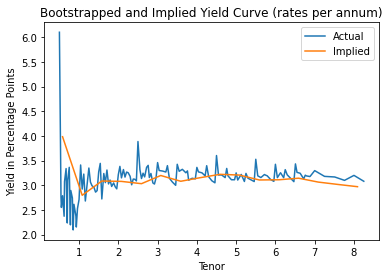

In [338]:
'''
Presents implied and actual yield curve as a plot
'''
shadow_ttm = ((shadow_px.index - datetime.datetime.now()) / datetime.timedelta(days=365)).to_list()
shadow_factors = shadow_px['shadow price'].to_list()
implied_rates = [-np.log(shadow_factors[i]) / shadow_ttm[i] for i in range(len(shadow_ttm))]

implied_rates_df = pd.DataFrame(
                        data = [shadow_ttm, implied_rates],
                        index=['ttm','implied_rate']
                    )

implied_rates_df = (implied_rates_df
                        .transpose()
                        .round({'ttm':round_to})
                        .set_index('ttm')
                    )

plt.plot(rates[0.5:8.5] * 100)
plt.plot(implied_rates_df * 100)
plt.title('Bootstrapped and Implied Yield Curve (rates per annum)')
plt.xlabel('Tenor')
plt.ylabel('Yield in Percentage Points')
plt.legend(['Actual', 'Implied'])

In [339]:
'''

'''

md(''' 
##### <center> Sensitivity Analysis - Shadow Prices  </center>

<center>

{}

'''.format((implied_rates_df*100).to_markdown(colalign = ("right",)))
)

 
##### <center> Sensitivity Analysis - Shadow Prices  </center>

<center>

|   ttm |   implied_rate |
|------:|---------------:|
|  0.58 |        3.98323 |
|  1.08 |        2.79683 |
|  1.58 |        3.08572 |
|  2.08 |        3.07789 |
|  2.59 |        3.03183 |
|  3.08 |        3.19753 |
|  3.59 |        3.08065 |
|  4.08 |        3.15268 |
|  4.59 |        3.22125 |
|  5.08 |        3.20655 |
|  5.59 |        3.10678 |
|  6.09 |        3.1111  |
|  6.59 |        3.14281 |
|  7.09 |        3.06415 |
|  7.59 |        3.01637 |
|  8.09 |        2.97075 |



# P5

In [340]:
'''
Aggregates cashflow matrix and ref data for immunization
---
Puts cashflow matrix into a dataframe for merging
merges possible bond ref data with cashflow matrix
cleans resulting dataframe

NOTE: MATH NEEDS WORK HERE BUT WE CAN FIGURE OUT
from here: use ttm and col_num against calculated curve to find appropriate measure
        pv_factor = exp{-rt} = exp{- () * (ttm)}
'''
cf_df = pd.DataFrame(cf_matrix, index=dec_var_names.to_list())

cf_df = pd.merge(                                                           # Combines possible bonds with cashflow matrix
    left = possibilities,                                                   # possible bonds - SAME DF AS DEDICATION
    right = cf_df,                                                          # Cashflow matrix - NP ARRAY FROM DEDICATION AS DF FOR MERGING
    how='inner',                                                            # Catches any missed bonds on merge
    left_on='ref_data',                                                     # possibilities not indexed by bond name - CHAZ IS THIS SOMETHING WE CAN ADJUST OR NO?????????????????????
    right_index=True                                                        # Casflow df indexed by bond name
)

cf_df = (cf_df
            .drop(['COUPON','period','face'],axis=1)                        # Drops unnecessary ref data
            .set_index('ref_data')                                          # Sets index to bond name
            .round({'ttm':round_to})                                        # rounds time to maturity to 2 decimal places -- allows use of derived term structure (indexed by hundredths)
        )

cf_df

,CHG,px_last,ttm,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
ref_data,,,,,,,,,,,,,,,,,,,
T 0.0 05/05/22,0.025,99.942,-0.03,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T 0.0 05/10/22,-0.018,99.925,-0.02,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T 0.0 05/12/22,0.005,99.857,-0.01,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T 1.75 05/15/22,-0.004,100.024,-0.00,100.8750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T 2.125 05/15/22,-0.002,100.030,-0.00,101.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T 6.125 08/15/29,-0.91,120.100,7.25,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,103.0625,0.0000
T 1.75 11/15/29,-0.922,91.182,7.51,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,100.8750,0.0000
T 1.5 02/15/30,-0.928,89.186,7.76,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,100.7500


In [341]:
'''
Create PResent Value, Duration, and Convexity factors for all possible time index based on derived rates curve
'''
t = rates.index
r = rates['rate']
npv_factor = np.exp(-r*t)
dur_factor = (t / (1+r)) * np.exp(-r*t)
con_factor = ((t*(t+1))/ (1+r)**2) * np.exp(-r*t)

In [342]:
'''
Calculates npv, duration, and convexity terms for all bonds consiuder in problem
'''
npvs=[]
durs=[]
cons=[]
for bond in cf_df.index:
    bond_df = cf_df.loc[bond]
    bond_ttm = bond_df.loc['ttm']
    bond_cf_stream = bond_df.loc[0:]
    eo_cfs = bond_cf_stream.idxmax()
    cpn_ttm = [(bond_ttm - 0.5*i).round(round_to) for i in range(eo_cfs+1)]
    bond_cf_ttm = pd.Series(data=bond_df.loc[0:eo_cfs].to_list(), index=reversed(cpn_ttm))

    bond_npv = sum([bond_cf_ttm.loc[i] * npv_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])
    bond_dur = sum([bond_cf_ttm.loc[i] * dur_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])
    bond_con = sum([bond_cf_ttm.loc[i] * con_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])

    npvs.append(bond_npv)
    durs.append(bond_dur)
    cons.append(bond_con)

immunization_df = pd.DataFrame([npvs, durs, cons], columns=cf_df.index, index=['npv','duration','convexity']).transpose()

TypeError: reduction operation 'argmax' not allowed for this dtype

In [343]:
'''
Solves immunization portfolio
'''
bond_count = LpVariable.dicts('Bonds',dec_var_names,lowBound=0)

immunization = LpProblem('immunization', LpMinimize)

immunization += lpSum([cf_df['px_last'].loc[i] * bond_count[i] for i in dec_var_names])
immunization += lpSum([immunization_df['npv'].loc[i] * bond_count[i] for i in dec_var_names]) == npv
immunization += lpSum([immunization_df['duration'].loc[i] * bond_count[i] for i in dec_var_names]) == dur
immunization += lpSum([immunization_df['convexity'].loc[i] * bond_count[i] for i in dec_var_names]) == con

immunization.solve()

KeyError: 'T 0.0 05/05/22'

In [ ]:
'''
Print Solution to Immunized portfolio
'''
bonds_fin = pd.DataFrame([[v.name[6:] for v in immunization.variables()], [v.varValue for v in immunization.variables()]], index=['bond','amt']).transpose().set_index('bond')
bonds_fin[bonds_fin['amt']>0]

md(
''' 
##### <center> Portoflio Allocation - Immunization  </center>

<center> Immunized Portfolio Value of ${:.2f} MM  </center> <br>


<center>

{}

'''.format(value(immunization.objective.value()) / 1000, bonds_fin[bonds_fin['amt']>0].to_markdown(colalign = ("right",))))

 
##### <center> Portoflio Allocation - Immunization  </center>

<center> Immunized Portfolio Value of $116.85 MM  </center> <br>


<center>

|             bond |     amt |
|-----------------:|--------:|
| T_6.125_08_15_29 | 169.295 |
| T_6.625_02_15_27 | 728.029 |
|  T_7.25_08_15_22 | 118.148 |



# Problem 6

In [ ]:
'''
Immunization part
Calculates npv, duration, and convexity terms for all bonds considered in the problem
FROM period 7-16
'''

ded_period = 6
imm_period = 5
imm_start_period = len(data_prompt) - imm_period*2
imm_end_period = len(data_prompt)

In [ ]:
'''
Solves combined portfolio
'''
bond_q = LpVariable.dicts('Bond',dec_var_names,lowBound=0)
excess_cf = LpVariable.dicts('ExcessCf', periods[:ded_period+1], lowBound=0)


combined = LpProblem('Combined', LpMinimize)

combined += lpSum([cf_df['px_last'][i] * bond_q[i] for i in dec_var_names]) + excess_cf[0] 

for i in range(0,ded_period):
    combined += lpSum([cf_df[i][j]*bond_q[j] for j in dec_var_names]) + excess_cf[i]- excess_cf[i+1] == liabilities[i]

combined += lpSum([immunization_df['npv'][i] * bond_q[i] for i in dec_var_names]) == npv
combined += lpSum([immunization_df['duration'][i] * bond_q[i] for i in dec_var_names]) == dur
combined += lpSum([immunization_df['convexity'][i] * bond_q[i] for i in dec_var_names]) == con

combined.solve()

1

In [ ]:
'''
Print Solution to Combined portfolio
'''
bonds_comb = pd.DataFrame( 
            [v.varValue for v in combined.variables() if v.varValue > 0], 
            index=[str(v.name[:-8].replace('Bond', '').replace('_', ' ') + v.name[-8:].replace('_', '/'))
            if v.name[0] == 'B' else str(r'$\text{Excess}_' + v.name[-1] + '$')
            for v in combined.variables() if v.varValue > 0], 
            columns=['Quantity'])

bonds_comb.index.name = 'Bonds/Excess Cashflows'



In [ ]:
md(''' 
##### <center> Portoflio Allocation - Combined  </center>

<center> Combined Portfolio Value of ${:.2f} MM  </center> <br>


<center>

{}

'''.format(value(combined.objective) / 1000, bonds_comb.to_markdown(colalign = ("right",)))
)

 
##### <center> Portoflio Allocation - Combined  </center>

<center> Combined Portfolio Value of $119.46 MM  </center> <br>


<center>

|   Bonds/Excess Cashflows |   Quantity |
|-------------------------:|-----------:|
|         T 0.125 12/15/23 |    76.0849 |
|          T 0.25 05/31/25 |    96.6462 |
|          T 0.25 06/15/23 |    85.9775 |
|          T 0.25 06/15/24 |    66.1325 |
|          T 0.75 01/31/28 |   680.896  |
|           T 1.0 12/15/24 |    86.2152 |
|          T 1.25 04/30/28 |   108.737  |
|         T 1.625 12/15/22 |    87.4755 |
|        $\text{Excess}_0$ |  1779.12   |



# P7

I thought the best way to solve this was to think of the trade balance as the objective. If we are going to buy and simultaniously short a bucket of bonds, and hold to each their maturities, then means $\text{excess}_i$ is not a decision variable anymore and $\text{excess}_0$ is a given by the new decision variables. A new decision variable arises and that is the "excess spent". 

We can think of what was excess as now our reserve funds from the trade balance and it gets diminished every time the decision variable "excess spent" is used. The constraints are pretty straight forward from there.

Why this works?
- Ans: I believe these new constraint bound the objective. Are we essentialy using the objective inside of the constraints, yes, but I do not think that violates any rules

In [344]:
'''Getting data how I want it'''
data = term_structure_df
Bid_p = data['BID'].to_list()[0:len(cf_matrix)]
Ask_p = data['ASKED'].to_list()[0:len(cf_matrix)]
Bid_p_fix = [Bid_p[i] 
            if Bid_p[i] > 10 else 100 - Bid_p[i]
            for i in range(0,len(Bid_p))]
Ask_p_fix = [Ask_p[i] 
            if Ask_p[i] > 10 else 100 - Ask_p[i]
            for i in range(0,len(Ask_p))]

In [345]:
'''Solving for the dedicated portfolio'''

# Making variable list of strings
periods = [i for i in range(0,len(cf_matrix[0])+1)]
excess_from_arb_left = [0*i for i in periods]


# Dictionary of period constraints
period_dict = {}
for i in range(0,len(cf_matrix[0])):
    period_dict['Period {}'.format(i+1)] = dict(zip(dec_var_names,[cf_matrix[j][i] for j in range(0,len(cf_matrix))]))

# Dictionary with tickers and prices for both bid and ask
bids = dict(zip(dec_var_names, Bid_p_fix))
asks = dict(zip(dec_var_names, Ask_p_fix))

# Decision Vars

quantity_s = LpVariable.dict('S', dec_var_names, lowBound=0)                # Qauntity Short
quantity_l = LpVariable.dict('L', dec_var_names, lowBound=0)                # Qauntity Long
excess_spent = LpVariable.dict('reserve_used', periods, lowBound=0)     # Reserves spent at time t


# Intializing the Problem
dedication_2 = LpProblem('Shorts', LpMinimize)

# Objective function
dedication_2 += lpSum([asks[i]*quantity_l[i] for i in dec_var_names]) - lpSum([bids[i]*quantity_s[i] for i in dec_var_names]) + excess_spent[0]

# Constraints

for i in range(0,len(cf_matrix[0])):
    # Liabilties constraint
    dedication_2 += lpSum([period_dict['Period {}'.format(i+1)][j]*quantity_l[j] for j in dec_var_names]) - lpSum([period_dict['Period {}'.format(i+1)][j]*quantity_s[j] for j in dec_var_names]) + excess_spent[i] - excess_spent[i+1] == liabilities[i]/1000
    # Constraint on the on the reserves at time t                                                                                        #sum of the "excess spent" so far

dedication_2 += lpSum([asks[i]*quantity_l[i] for i in dec_var_names]) - lpSum([bids[i]*quantity_s[i] for i in dec_var_names]) + excess_spent[0]  >= 0
  





In [ ]:
dedication_2.solve()
LpStatus[dedication_2.status]



'Optimal'

In [ ]:
comp_dates = pd.DataFrame(
    [v.varValue for v in dedication_2.variables() if  v.varValue > 0],
    index=[v.name for v in dedication_2.variables() if v.varValue > 0 ],
    columns=['Quantity']
    )

In [ ]:
comp_dates = pd.DataFrame(
    [v.varValue for v in dedication_2.variables() if v.name[2] == 'T' and v.varValue > 0],
    index=[str(v.name[:-8].replace('_', ' ')+v.name[-8:].replace('_', '/')) for v in dedication_2.variables() if v.name[2] == 'T' and v.varValue > 0 ],
    columns=['Quantity']
    )
comp_reserve = pd.DataFrame(
    [v.varValue for v in dedication_2.variables() if v.name[0] == 'r' and v.varValue > 0],
    index=[str(v.name.replace('_', ' ')) for v in dedication_2.variables() if v.name[0] == 'r' and v.varValue > 0 ],
    columns=['Quantity']
    )
'''Manipulating the dataframe so that it will be sorted by maturity'''
maturities_ded_2 = [datetime.datetime.strptime(i[-8:], '%m/%d/%y') for i in comp_dates.index.to_list()]
comp_dates.reset_index(inplace=True)
comp_dates['Dates'] = maturities_ded_2
comp_dates.set_index('Dates',inplace=True)
comp_dates.sort_index(axis=0, inplace=True)
comp_dates.set_index('index', inplace = True)

composition = pd.concat([comp_dates,comp_reserve])

In [ ]:
'''Printing Solutions'''
'''Note that the portfolio cost is a negative because our trade balance was positive'''
md(''' 
##### <center> Dedication Portfolio Cost & Composition  </center>

<center>

Portfolio Cost $ = \${:.2f} $ <br>

</center>

<center>

{}

'''.format(dedication_2.objective.value()*-1000000,composition.to_markdown(colalign = ("right",))))

 
##### <center> Dedication Portfolio Cost & Composition  </center>

<center>

Portfolio Cost $ = \$79.20 $ <br>

</center>

<center>

|                    |   Quantity |
|-------------------:|-----------:|
|   S T 0.0 06/16/22 |  2.04863   |
| S T 0.137 12/31/22 | 63.2136    |
| L T 7.125 02/15/23 | 61.1449    |
|  L T 6.25 08/15/23 |  0.0563529 |
|   L T 2.0 05/31/24 |  0.0481139 |
|   L T 1.5 11/30/24 |  0.0685951 |
| L T 7.625 02/15/25 |  0.154094  |
|  L T 0.75 05/31/26 |  0.104984  |
|  L T 6.75 08/15/26 |  0.0753781 |
| L T 6.625 02/15/27 |  0.0479221 |
| L T 6.375 08/15/27 |  0.0395095 |
| L T 2.875 05/15/28 |  0.0607689 |
|   L T 5.5 08/15/28 |  0.0816424 |
|  L T 5.25 02/15/29 |  0.0638876 |
| L T 6.125 08/15/29 |  0.0755646 |
|  L T 6.25 05/15/30 |  0.0678788 |
|     reserve used 6 |  7.49844   |



Found Arbitrage 
not feasible: 63 and 61 mill of one bond


In [350]:
'''Data Manipulation'''
data = term_structure_df
Bid_p = data['BID'].to_list()[0:len(cf_matrix)]
Ask_p = data['ASKED'].to_list()[0:len(cf_matrix)]
Bid_p_fix = [Bid_p[i] 
            if Bid_p[i] > 10 else 100 - Bid_p[i]
            for i in range(0,len(Bid_p))]
Ask_p_fix = [Ask_p[i] 
            if Ask_p[i] > 10 else 100 - Ask_p[i]
            for i in range(0,len(Ask_p))]
            
'''Solving for the dedicated portfolio'''

# Making variable list of strings
periods = [i for i in range(0,len(cf_matrix[0])+1)]
excess_from_arb_left = [0*i for i in periods]


# Dictionary of period constraints
period_dict = {}
for i in range(0,len(cf_matrix[0])):
    period_dict['Period {}'.format(i+1)] = dict(zip(dec_var_names,[cf_matrix[j][i] for j in range(0,len(cf_matrix))]))

# Dictionary with tickers and prices for both bid and ask
bids = dict(zip(dec_var_names, Bid_p_fix))
asks = dict(zip(dec_var_names, Ask_p_fix))

# Decision Vars

quantity_s = LpVariable.dict('S', dec_var_names, lowBound=0)                # Qauntity Short
quantity_l = LpVariable.dict('L', dec_var_names, lowBound=0)                # Qauntity Long
excess_spent = LpVariable.dict('reserve_used', periods, lowBound=0)     # Reserves spent at time t


# Intializing the Problem
dedication_2 = LpProblem('Shorts', LpMinimize)

# Objective function
dedication_2 +=   lpSum([bids[i]*quantity_s[i] for i in dec_var_names]) - lpSum([asks[i]*quantity_l[i] for i in dec_var_names])

# Constraints

for i in range(0,len(cf_matrix[0])):
    # Liabilties constraint
    dedication_2 += lpSum([period_dict['Period {}'.format(i+1)][j]*quantity_l[j] for j in dec_var_names]) - lpSum([period_dict['Period {}'.format(i+1)][j]*quantity_s[j] for j in dec_var_names]) - excess_spent[i] + excess_spent[i+1] == liabilities[i]/1000
    # Constraint on the on the reserves at time t                                                                                        #sum of the "excess spent" so far
    dedication_2 += lpSum([bids[j]*quantity_s[j] for j in dec_var_names]) - lpSum([asks[j]*quantity_l[j] for j in dec_var_names]) - lpSum([excess_spent[j+1] for j in range(0,i)]) >= 0
    # Constraint stating that the "excess spent" at time t must be <= the current reserves.
    dedication_2 += excess_spent[i+1] <= lpSum([bids[i]*quantity_s[i] for i in dec_var_names]) - lpSum([asks[i]*quantity_l[i] for i in dec_var_names]) - lpSum([excess_spent[j+1] for j in range(0,i)])    

dedication_2.solve()

1

In [351]:
composition = pd.DataFrame(
    [v.varValue for v in dedication_2.variables() if v.varValue > 0],
    index=[v.name for v in dedication_2.variables() if v.varValue > 0],
    columns=['Quantity']
    )



In [352]:
dedication_2.objective.value()*-1000000

-50.90918148198398

In [353]:
composition

,Quantity
L_T_0.25_06_15_23,0.065522
L_T_0.25_06_15_24,0.047342
L_T_0.75_11_15_24,0.067401
L_T_2.25_11_15_27,0.040315
L_T_2.875_05_15_28,0.060769
L_T_5.25_02_15_29,0.063888
L_T_5.5_08_15_28,0.081642
L_T_6.0_02_15_26,0.103041
L_T_6.125_08_15_29,0.075565
L_T_6.25_05_15_30,0.067879


In [ ]:
'''Manipulating the dataframe so that it will be sorted by maturity and look nice'''
composition['Dates'] = [datetime.datetime.strptime(i[-8:], '%m/%d/%y') for i in composition.index.to_list()]
composition.reset_index(inplace=True)
composition.set_index('Dates',inplace=True)
composition.sort_index(axis=0, inplace=True)
composition.set_index('index', inplace = True)

'''Printing Solutions'''
'''Note that the portfolio cost is a negative because our trade balance was positive'''
md(''' 
##### <center> Dedication Portfolio Cost & Composition  </center>

<center>

Portfolio Cost $ = \${:.2f} $ <br>

</center>

<center>

{}

'''.format(dedication_2.objective.value()*-1000000,composition.to_markdown(colalign = ("right",))))

ValueError: time data '05_31_26' does not match format '%m/%d/%y'

In [ ]:
data[data['ref_data'] == 'T 0.0 06/16/22']

,MATURITY,COUPON,BID,ASKED,ASKED YIELD,px_last,ttm,ref_data
15,2022-06-16,0.0,0.638,0.628,0.637,99.372,0.085343,T 0.0 06/16/22


# P7 constraint on the transaction amount

I looked through some data on some auctions and it seems as though we can say no more than 5 mill per transaction because that is really how much 

In [ ]:
'''Solving for the dedicated portfolio'''

# Making variable list of strings
periods = [i for i in range(0,len(cf_matrix[0])+1)]
excess_from_arb_left = [0*i for i in periods]


# Dictionary of period constraints
period_dict = {}
for i in range(0,len(cf_matrix[0])):
    period_dict['Period {}'.format(i+1)] = dict(zip(dec_var_names,[cf_matrix[j][i] for j in range(0,len(cf_matrix))]))

# Dictionary with tickers and prices for both bid and ask
bids = dict(zip(dec_var_names, Bid_p_fix))
asks = dict(zip(dec_var_names, Ask_p_fix))

# Decision Vars

quantity_s = LpVariable.dict('S', dec_var_names, lowBound=0)                # Qauntity Short
quantity_l = LpVariable.dict('L', dec_var_names, lowBound=0)                # Qauntity Long
excess_spent = LpVariable.dict('reserve_used', periods[1:], lowBound=0)     # Reserves spent at time t


# Intializing the Problem
dedication_2_trans_lim = LpProblem('Shorts', LpMaximize)

# Objective function
dedication_2_trans_lim += lpSum([bids[i]*quantity_s[i] for i in dec_var_names]) - lpSum([asks[i]*quantity_l[i] for i in dec_var_names]) - lpSum([excess_spent[i] for i in periods[1:]])

# Constraints

for i in range(0,len(cf_matrix[0])):
    # Liabilties constraint
    dedication_2_trans_lim += lpSum([period_dict['Period {}'.format(i+1)][j]*quantity_l[j] for j in dec_var_names]) - lpSum([period_dict['Period {}'.format(i+1)][j]*quantity_s[j] for j in dec_var_names]) + excess_spent[i+1] == liabilities[i]/1000
    # Constraint on the on the reserves at time t                                                                                        #sum of the "excess spent" so far
    dedication_2_trans_lim += lpSum([bids[j]*quantity_s[j] for j in dec_var_names]) - lpSum([asks[j]*quantity_l[j] for j in dec_var_names]) >= 0
    # Constraint stating that the "excess spent" at time t must be <= the current reserves.
    dedication_2_trans_lim += excess_spent[i+1] <= lpSum([bids[i]*quantity_s[i] for i in dec_var_names]) - lpSum([asks[i]*quantity_l[i] for i in dec_var_names]) - lpSum([excess_spent[j+1] for j in range(0,i)])   


for i in dec_var_names:

    dedication_2_trans_lim += quantity_l[i] <= 15

    dedication_2_trans_lim += quantity_s[i] <= 15




In [ ]:
dedication_2_trans_lim.solve()
LpStatus[dedication_2_trans_lim.status]

'Optimal'

In [ ]:
dedication_2_trans_lim.objective.value()

1009.0066099193476

In [ ]:
min(data['COUPON'])

0.0

In [ ]:
composition = pd.DataFrame(
    [v.varValue for v in dedication_2_trans_lim.variables() if v.varValue > 0],
    index=[v.name for v in dedication_2_trans_lim.variables() if v.varValue > 0],
    columns=['Quantity']
    )

In [ ]:
'''Printing Solutions'''
'''Note that the portfolio cost is a negative because our trade balance was positive'''
md(''' 
##### <center> Dedication Portfolio Cost & Composition  </center>

<center>

Portfolio Cost $ = \${:.2f} $ <br>

</center>

<center>

{}

'''.format(dedication_2_trans_lim.objective.value()*-1000000,composition.to_markdown(colalign = ("right",))))

 
##### <center> Dedication Portfolio Cost & Composition  </center>

<center>

Portfolio Cost $ = \$-1009006609.92 $ <br>

</center>

<center>

|                    |   Quantity |
|-------------------:|-----------:|
|   L_T_0.0_08_04_22 |  15        |
|   L_T_0.0_08_11_22 |  15        |
|   L_T_0.0_08_18_22 |  15        |
|   L_T_0.0_08_25_22 |  15        |
|   L_T_0.0_09_01_22 |  15        |
|   L_T_0.0_09_08_22 |  15        |
|   L_T_0.0_09_15_22 |  15        |
|   L_T_0.0_09_22_22 |  15        |
|   L_T_0.0_09_29_22 |  15        |
|   L_T_0.0_10_06_22 |  15        |
|   L_T_0.0_10_13_22 |  15        |
|   L_T_0.0_10_20_22 |  15        |
|   L_T_0.0_10_27_22 |  15        |
|   L_T_0.0_11_03_22 |  15        |
|   L_T_0.0_11_10_22 |  15        |
|   L_T_0.0_12_01_22 |  15        |
| L_T_0.125_05_31_23 |  15        |
| L_T_0.125_09_30_22 |  15        |
| L_T_0.125_10_15_23 |  15        |
| L_T_0.125_10_31_22 |  15        |
| L_T_0.125_11_30_22 |  15        |
| L_T_0.125_12_15_23 |  15        |
|  L_T_0.25_05_15_24 |  15        |
|  L_T_0.25_05_31_25 |  15        |
|  L_T_0.25_06_15_23 |  15        |
|  L_T_0.25_06_15_24 |  15        |
|  L_T_0.25_10_31_25 |  15        |
|  L_T_0.25_11_15_23 |  15        |
| L_T_0.375_04_15_24 |  15        |
| L_T_0.375_11_30_25 |  15        |
|   L_T_0.5_03_15_23 |  15        |
|   L_T_0.5_03_31_25 |  15        |
|   L_T_0.5_05_31_27 |  15        |
|   L_T_0.5_10_31_27 |  15        |
| L_T_0.625_03_31_27 |  15        |
| L_T_0.625_05_15_30 |  15        |
|  L_T_0.75_05_31_26 |  15        |
|  L_T_0.75_11_15_24 |  15        |
| L_T_0.875_09_30_26 |  15        |
|   L_T_1.0_12_15_24 |  15        |
| L_T_1.125_10_31_26 |  15        |
|  L_T_1.25_03_31_28 |  15        |
|  L_T_1.25_04_30_28 |  15        |
|  L_T_1.25_05_31_28 |  15        |
|  L_T_1.25_08_31_24 |  15        |
| L_T_1.375_08_31_26 |  15        |
| L_T_1.375_09_30_23 |  15        |
| L_T_1.375_10_31_28 |  15        |
|   L_T_1.5_01_15_23 |  15        |
|   L_T_1.5_01_31_27 |  15        |
|   L_T_1.5_02_28_23 |  15        |
|   L_T_1.5_03_31_23 |  15        |
|   L_T_1.5_11_30_24 |  15        |
| L_T_1.625_02_15_26 |  15        |
| L_T_1.625_04_30_23 |  15        |
| L_T_1.625_05_15_26 |  15        |
| L_T_1.625_05_31_23 |  15        |
| L_T_1.625_09_30_26 |  15        |
| L_T_1.625_10_31_23 |  15        |
| L_T_1.625_10_31_26 |  15        |
| L_T_1.625_11_30_26 |  15        |
|  L_T_1.75_05_15_22 |  15        |
|  L_T_1.75_05_15_23 |  15        |
|  L_T_1.75_05_31_22 |  15        |
|  L_T_1.75_06_15_22 |  15        |
| L_T_1.875_05_31_22 |  15        |
| L_T_1.875_07_31_22 |  15        |
| L_T_1.875_08_31_22 |  15        |
| L_T_1.875_09_30_22 |  15        |
| L_T_1.875_10_31_22 |  15        |
|   L_T_2.0_02_15_25 |  15        |
|   L_T_2.0_04_30_24 |  15        |
|   L_T_2.0_05_31_24 |  15        |
|   L_T_2.0_07_31_22 |  15        |
|   L_T_2.0_10_31_22 |  15        |
|   L_T_2.0_11_15_26 |  13.1191   |
|   L_T_2.0_11_30_22 |  15        |
| L_T_2.125_05_15_22 |  15        |
| L_T_2.125_05_31_26 |  15        |
| L_T_2.125_06_30_22 |  15        |
| L_T_2.125_07_31_24 |  15        |
| L_T_2.125_09_30_24 |  15        |
| L_T_2.125_11_30_23 |  15        |
| L_T_2.125_11_30_24 |  15        |
|  L_T_2.25_03_31_24 |  10.2953   |
|  L_T_2.25_03_31_26 |  15        |
|  L_T_2.25_04_30_24 |  15        |
|  L_T_2.25_08_15_27 |  15        |
|  L_T_2.25_10_31_24 |  15        |
|  L_T_2.25_11_15_24 |  15        |
|  L_T_2.25_11_15_27 |  15        |
|  L_T_2.25_12_31_24 |  15        |
| L_T_2.375_01_31_23 |   7.21611  |
| L_T_2.375_02_29_24 |  15        |
| L_T_2.375_03_31_29 |  14.4181   |
| L_T_2.375_05_15_27 |  15        |
| L_T_2.375_05_15_29 |  15        |
|   L_T_2.5_01_31_24 |  15        |
|   L_T_2.5_02_28_26 |  15        |
|   L_T_2.5_03_31_23 |  15        |
|   L_T_2.5_04_30_24 |  15        |
|   L_T_2.5_05_15_24 |  15        |
| L_T_2.625_02_28_23 |  15        |
| L_T_2.625_03_31_25 |  15        |
| L_T_2.625_04_15_25 |  15        |
|  L_T_2.75_02_28_25 |  15        |
|  L_T_2.75_04_30_23 |  15        |
|  L_T_2.75_04_30_27 |  13.2015   |
|  L_T_2.75_05_15_25 |  15        |
|  L_T_2.75_05_31_23 |  15        |
|  L_T_2.75_06_30_25 |  15        |
|  L_T_2.75_07_31_23 |  15        |
|  L_T_2.75_08_31_23 |  15        |
|  L_T_2.75_08_31_25 |  15        |
|  L_T_2.75_11_15_23 |  15        |
| L_T_2.875_04_30_29 |  15        |
| L_T_2.875_05_15_28 |  13.7444   |
| L_T_2.875_08_15_28 |  15        |
| L_T_2.875_09_30_23 |  15        |
| L_T_2.875_10_31_23 |  15        |
| L_T_2.875_11_30_23 |  15        |
|   L_T_3.0_09_30_25 |  15        |
|   L_T_3.0_10_31_25 |  15        |
| L_T_3.125_11_15_28 |  15        |
|  L_T_5.25_02_15_29 |  15        |
|   L_T_5.5_08_15_28 |  15        |
|   L_T_6.0_02_15_26 |  15        |
| L_T_6.125_08_15_29 |  15        |
|  L_T_6.25_05_15_30 |   0.131515 |
|  L_T_6.25_08_15_23 |  15        |
| L_T_6.375_08_15_27 |  15        |
| L_T_6.625_02_15_27 |  15        |
|  L_T_6.75_08_15_26 |  15        |
| L_T_6.875_08_15_25 |  15        |
| L_T_7.125_02_15_23 |  15        |
|  L_T_7.25_08_15_22 |  15        |
|   L_T_7.5_11_15_24 |  15        |
| L_T_7.625_02_15_25 |  15        |
|   S_T_0.0_01_26_23 |  15        |
|   S_T_0.0_02_23_23 |  15        |
|   S_T_0.0_03_23_23 |  15        |
|   S_T_0.0_04_20_23 |  15        |
|   S_T_0.0_05_17_22 |  15        |
|   S_T_0.0_05_19_22 |  15        |
|   S_T_0.0_05_24_22 |  15        |
|   S_T_0.0_05_26_22 |  15        |
|   S_T_0.0_05_31_22 |  15        |
|   S_T_0.0_06_02_22 |  15        |
|   S_T_0.0_06_07_22 |  15        |
|   S_T_0.0_06_09_22 |  15        |
|   S_T_0.0_06_14_22 |  15        |
|   S_T_0.0_06_16_22 |  15        |
|   S_T_0.0_06_21_22 |  15        |
|   S_T_0.0_06_23_22 |  15        |
|   S_T_0.0_06_28_22 |  15        |
|   S_T_0.0_06_30_22 |  15        |
|   S_T_0.0_07_05_22 |  15        |
|   S_T_0.0_07_07_22 |  15        |
|   S_T_0.0_07_12_22 |  15        |
|   S_T_0.0_07_14_22 |  15        |
|   S_T_0.0_07_21_22 |  15        |
|   S_T_0.0_07_28_22 |  15        |
|   S_T_0.0_12_29_22 |  15        |
| S_T_0.125_01_15_24 |  15        |
| S_T_0.125_01_31_23 |  15        |
| S_T_0.125_02_15_24 |  15        |
| S_T_0.125_02_28_23 |  15        |
| S_T_0.125_03_31_23 |  15        |
| S_T_0.125_04_30_23 |  15        |
| S_T_0.125_05_15_23 |  15        |
| S_T_0.125_05_31_22 |  15        |
| S_T_0.125_06_30_22 |  15        |
| S_T_0.125_06_30_23 |  15        |
| S_T_0.125_07_15_23 |  15        |
| S_T_0.125_07_31_22 |  15        |
| S_T_0.125_07_31_23 |  15        |
| S_T_0.125_08_15_23 |  15        |
| S_T_0.125_08_31_22 |   8.51794  |
| S_T_0.125_08_31_23 |  15        |
| S_T_0.125_09_15_23 |  15        |
| S_T_0.137_12_31_22 |  15        |
|  S_T_0.25_03_15_24 |  15        |
|  S_T_0.25_04_15_23 |  15        |
|  S_T_0.25_06_30_25 |  15        |
|  S_T_0.25_07_31_25 |  15        |
|  S_T_0.25_08_31_25 |  15        |
|  S_T_0.25_09_30_23 |  15        |
|  S_T_0.25_09_30_25 |   3.13183  |
| S_T_0.375_01_31_26 |  15        |
| S_T_0.375_04_30_25 |  15        |
| S_T_0.375_07_15_24 |  15        |
| S_T_0.375_07_31_27 |  15        |
| S_T_0.375_08_15_24 |  15        |
| S_T_0.375_09_15_24 |   4.45637  |
| S_T_0.375_10_31_23 |  15        |
| S_T_0.375_12_31_25 |  15        |
|   S_T_0.5_02_28_26 |  15        |
|   S_T_0.5_06_30_27 |  15        |
|   S_T_0.5_08_31_27 |  15        |
|   S_T_0.5_11_30_23 |  15        |
| S_T_0.625_07_31_26 |  15        |
| S_T_0.625_10_15_24 |  15        |
| S_T_0.625_11_30_27 |   1.56132  |
| S_T_0.625_12_31_27 |  15        |
|  S_T_0.75_01_31_28 |  15        |
|  S_T_0.75_03_31_26 |  15        |
|  S_T_0.75_04_30_26 |  15        |
|  S_T_0.75_08_31_26 |  15        |
|  S_T_0.75_12_31_23 |  15        |
| S_T_0.875_01_31_24 |  15        |
| S_T_0.875_06_30_26 |  15        |
|   S_T_1.0_07_31_28 |  15        |
| S_T_1.125_01_15_25 |  15        |
| S_T_1.125_02_28_25 |  15        |
| S_T_1.125_02_28_27 |  15        |
| S_T_1.125_02_29_28 |  15        |
| S_T_1.125_08_31_28 |  15        |
|  S_T_1.25_06_30_28 |  15        |
|  S_T_1.25_07_31_23 |  15        |
|  S_T_1.25_09_30_28 |  15        |
|  S_T_1.25_11_30_26 |  15        |
|  S_T_1.25_12_31_26 |  15        |
| S_T_1.375_01_31_25 |  15        |
| S_T_1.375_02_15_23 |  15        |
| S_T_1.375_06_30_23 |  15        |
| S_T_1.375_08_31_23 |   6.08722  |
| S_T_1.375_10_15_22 |  15        |
| S_T_1.375_12_31_28 |  15        |
|   S_T_1.5_02_15_25 |  15        |
|   S_T_1.5_02_15_30 |  15        |
|   S_T_1.5_02_29_24 |  15        |
|   S_T_1.5_08_15_22 |  15        |
|   S_T_1.5_08_15_26 |  15        |
|   S_T_1.5_09_15_22 |  15        |
|   S_T_1.5_09_30_24 |  15        |
|   S_T_1.5_10_31_24 |  15        |
| S_T_1.625_08_15_22 |  15        |
| S_T_1.625_08_15_29 |   0.185106 |
| S_T_1.625_08_31_22 |  15        |
| S_T_1.625_11_15_22 |  15        |
| S_T_1.625_12_15_22 |  15        |
|  S_T_1.75_01_31_29 |  15        |
|  S_T_1.75_03_15_25 |  15        |
|  S_T_1.75_06_30_24 |  15        |
|  S_T_1.75_07_15_22 |  15        |
|  S_T_1.75_07_31_24 |  15        |
|  S_T_1.75_09_30_22 |  15        |
|  S_T_1.75_11_15_29 |  15        |
|  S_T_1.75_12_31_24 |  15        |
|  S_T_1.75_12_31_26 |  15        |
| S_T_1.875_02_28_27 |  15        |
| S_T_1.875_02_28_29 |  15        |
| S_T_1.875_06_30_26 |  15        |
| S_T_1.875_07_31_26 |  15        |
| S_T_1.875_08_31_24 |  15        |
|   S_T_2.0_02_15_23 |  15        |
|   S_T_2.0_06_30_24 |  15        |
|   S_T_2.0_08_15_25 |  15        |
| S_T_2.125_02_29_24 |  15        |
| S_T_2.125_03_31_24 |  15        |
| S_T_2.125_05_15_25 |  15        |
| S_T_2.125_12_31_22 |  15        |
|  S_T_2.25_02_15_27 |  15        |
|  S_T_2.25_11_15_25 |  15        |
|  S_T_2.25_12_31_23 |  15        |
| S_T_2.375_04_30_26 |   2.487    |
| S_T_2.375_08_15_24 |  15        |
|   S_T_2.5_01_31_25 |  15        |
|   S_T_2.5_03_31_27 |  15        |
|   S_T_2.5_08_15_23 |  15        |
| S_T_2.625_01_31_26 |  15        |
| S_T_2.625_02_15_29 |  15        |
| S_T_2.625_06_30_23 |  15        |
| S_T_2.625_12_31_23 |  15        |
| S_T_2.625_12_31_25 |  15        |
|  S_T_2.75_02_15_24 |  15        |
|  S_T_2.75_02_15_28 |  15        |
| S_T_2.875_04_30_25 |   3.79848  |
| S_T_2.875_07_31_25 |  15        |
| S_T_2.875_11_30_25 |  15        |
|  S_T_5.25_11_15_28 |   1.15049  |
| S_T_6.125_11_15_27 |  15        |
|   S_T_6.5_11_15_26 |  15        |
| S_T_7.625_11_15_22 |  15        |



# P8

In [ ]:
'''Looking at the implied term structure of the last problem'''
o = [{'name':name, 'shadow price':c.pi} for name, c in dedication_2.constraints.items() if c.pi > 0]


In [ ]:
shadows = pd.DataFrame(
    o,
    index = data_prompt.index.tolist()
).drop(labels=['name'], axis = 1)

In [ ]:
shadows

,shadow price
2022-12-15,6.296923e-15
2023-06-15,6.312124e-15
2023-12-15,6.201100e-15
2024-06-15,6.308148e-15
2024-12-15,6.026772e-15
2025-06-15,5.749364e-15
2025-12-15,5.495436e-15
2026-06-15,5.794718e-15
2026-12-15,6.186104e-15
2027-06-15,6.052294e-15


In [ ]:
shadow_ttm = ((shadows.index - datetime.datetime.now()) / datetime.timedelta(days=365)).to_list()
shadow_ttm

[0.5839730849849696,
 1.082603221971271,
 1.5839730849849696,
 2.0853429479986683,
 2.586712811012367,
 3.0853429479986683,
 3.586712811012367,
 4.085342947998668,
 4.586712811012367,
 5.085342947998669,
 5.586712811012367,
 6.088082674026066,
 6.589452537039764,
 7.088082674026066,
 7.589452537039764,
 8.088082674026065]

In [ ]:
looper = shadows.index.tolist()
implied_rates = pd.DataFrame(
    [-np.log(shadows.loc[looper[i],'shadow price'])/shadow_ttm[i] for i in range(len(looper))],
    index = shadow_ttm,
    columns= ['implied rates']
)

In [ ]:
implied_rates

,implied rates
0.583973,55.993531
1.082603,30.201558
1.583973,20.653160
2.085343,15.679404
2.586713,12.657982
3.085343,10.627566
3.586713,9.154583
4.085343,8.024254
4.586713,7.132880
5.085343,6.437784


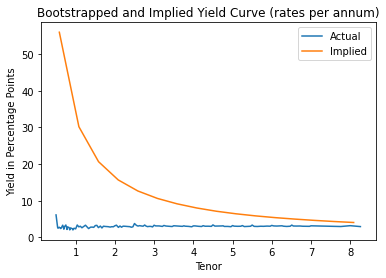

In [ ]:
plt.plot(rates[0.5:8.5] * 100)
plt.plot(implied_rates)
plt.title('Bootstrapped and Implied Yield Curve (rates per annum)')
plt.xlabel('Tenor')
plt.ylabel('Yield in Percentage Points')
plt.legend(['Actual', 'Implied'])

In [ ]:
possibilities

,COUPON,px_last,ttm,ref_data,period,face
bond#,,,,,,
1,1.750,100.010,-0.002328,T 1.75 05/15/22,1.0,100
2,2.125,100.012,-0.002328,T 2.125 05/15/22,1.0,100
3,0.000,99.352,0.003151,T 0.0 05/17/22,1.0,100
4,0.000,99.340,0.008631,T 0.0 05/19/22,1.0,100
5,0.000,99.320,0.022329,T 0.0 05/24/22,1.0,100
...,...,...,...,...,...,...
285,6.125,120.284,7.255206,T 6.125 08/15/29,15.0,100
286,1.750,92.076,7.507261,T 1.75 11/15/29,15.0,100
287,1.500,90.076,7.759316,T 1.5 02/15/30,16.0,100


In [ ]:
periods_and_ticks = pd.DataFrame(
    possibilities['period'].values.tolist(),
    index = possibilities['ref_data'].values.tolist(),
    columns=['period']
)

In [ ]:
'''Solving for the dedicated portfolio'''

# Making variable list of strings
periods = [i for i in range(0,len(cf_matrix[0])+1)]
excess_from_arb_left = [0*i for i in periods]


# Dictionary of period constraints
period_dict = {}
for i in range(0,len(cf_matrix[0])):
    period_dict['Period {}'.format(i+1)] = dict(zip(dec_var_names,[cf_matrix[j][i] for j in range(0,len(cf_matrix))]))

# Dictionary with tickers and prices for both bid and ask
bids = dict(zip(dec_var_names, Bid_p_fix))
asks = dict(zip(dec_var_names, Ask_p_fix))

# Decision Vars

quantity_s = LpVariable.dict('S', dec_var_names, lowBound=0)                # Qauntity Short
quantity_l = LpVariable.dict('L', dec_var_names, lowBound=0)                # Qauntity Long

y = LpVariable.dict('y_', dec_var_names, lowBound=0, cat= 'Binary')
z = LpVariable.dict('z_', dec_var_names, lowBound=0, cat = 'Binary')

# Intializing the Problem
dedication_3 = LpProblem('Part 8', LpMinimize)

# Objective function
dedication_3 += lpSum([bids[i]*quantity_s[i] for i in dec_var_names]) - lpSum([asks[i]*quantity_l[i] for i in dec_var_names]) 

# Constraints

for i in range(0,len(cf_matrix[0])):
    # Liabilties constraint
    dedication_3 += lpSum([period_dict['Period {}'.format(i+1)][j]*quantity_l[j] for j in dec_var_names]) - lpSum([period_dict['Period {}'.format(i+1)][j]*quantity_s[j] for j in dec_var_names]) == liabilities[i]/1000
    # Constraint stating that the "excess spent" at time t must be <= the current reserves.
    dedication_3 +=  lpSum([y[j] for j in dec_var_names if possibilities.loc[j,'period'] == i+1]) == lpSum([z[j] for j in dec_var_names if possibilities.loc[j,'period'] == i+1])







c:\Users\Chaz\AppData\Local\Programs\Python\Python39\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


KeyError: 'T 1.75 05/15/22'

In [ ]:
dedication_3.solve()
LpStatus[dedication_3.status]
dedication_3.objective.value()


In [ ]:
composition = pd.DataFrame(
    [v.varValue for v in dedication_2.variables() if v.varValue > 0],
    index=[str(v.name[:-8].replace('_', ' ')+v.name[-8:].replace('_', '/')) for v in dedication_2.variables() if v.varValue > 0],
    columns=['Quantity']
    )


In [ ]:
'''Manipulating the dataframe so that it will be sorted by maturity'''
maturities_ded_2 = [datetime.datetime.strptime(i[-8:], '%m/%d/%y') for i in composition.index.to_list()]

composition.reset_index(inplace=True)
composition['Dates'] = maturities_ded_2
composition.set_index('Dates',inplace=True)
composition.sort_index(axis=0, inplace=True)
composition.set_index('index', inplace = True)


In [ ]:
'''Printing Solutions'''
'''Note that the portfolio cost is a negative because our trade balance was positive'''
md(''' 
##### <center> Dedication Portfolio Cost & Composition  </center>

<center>

Portfolio Cost $ = \${:.2f} $ <br>

</center>

<center>

{}

'''.format(dedication_2.objective.value()*-1000000,composition.to_markdown(colalign = ("right",))))